# Cox Mixtures with Heterogeneous Effects Demo
<img align="left" width=20% src=https://ndownloader.figshare.com/files/34052981>

## 1. Introduction

Estimation of treatment efficacy of real-world clinical interventions involves working with continuous outcomes such as time-to-death, re-hospitalization, or a composite event that may be subject to censoring. Causal reasoning in such scenarios requires decoupling the effects of confounding physiological characteristics that affect baseline survival rates from the effects of the interventions being assessed. In this paper, we present a latent variable approach to model heterogeneous treatment effects by proposing that an individual can belong to one of latent clusters with distinct response characteristics. We show that this latent structure can mediate the base survival rates and helps determine the effects of an intervention. We demonstrate the ability of our approach to discover actionable phenotypes of individuals based on their treatment response on multiple large randomized clinical trials originally conducted to assess appropriate treatment strategies to reduce cardiovascular risk.

<img  src="https://ndownloader.figshare.com/files/34056269">

<img align="center" width=35% src="https://figshare.com/ndownloader/files/34056284">

## 2. Synthetic Data Example

In [1]:
import torch
from tqdm import tqdm 
import sys
sys.path.append('../auton_survival/')

from datasets import load_dataset
from example_utils import * 

# Load the synthetic dataset
outcomes, features, interventions = load_dataset(dataset='SYNTHETIC')

### Hyper-parameters

In [2]:
# Hyper-parameters
random_seed = 0
test_size = 0.25

# Split the synthetic data into training and testing data
import numpy as np

np.random.seed(random_seed)
n = features.shape[0] 

test_idx = np.zeros(n).astype('bool')
test_idx[np.random.randint(n, size=int(n*test_size))] = True 

features_tr = features.iloc[~test_idx] 
outcomes_tr = outcomes.iloc[~test_idx]
interventions_tr = interventions[~test_idx]
print(f'Number of training data points: {len(features_tr)}')

features_te = features.iloc[test_idx] 
outcomes_te = outcomes.iloc[test_idx]
interventions_te = interventions[test_idx]
print(f'Number of test data points: {len(features_te)}')

Number of training data points: 3899
Number of test data points: 1101


### Let us train a CMHE model via hyper-parameter tuning

In [3]:
# Hyper-parameters to train model
k = 1 
g = 2 
layers = [50] 

model_random_seed = 3
iters = 50
learning_rate = 0.001
batch_size = 128
vsize = 0.15
patience = 3
optimizer = "Adam"

In [4]:
def predict_treatment_phenotype_proba(model, x, a):
    """
    Using the trained CMHE model, find the probability that an individual 
    belongs to each treatment phenotype.
    """
    
    # Find the probability that an individual belongs to each treatment phenotype
    zeta_probs = torch.exp(model(x, a)[0]).sum(dim=1).detach().numpy()
   
    return zeta_probs

In [5]:
# Set torch and numpy random seeds
torch.manual_seed(model_random_seed)
np.random.seed(model_random_seed)

# Convert training data into torch tensors
x = torch.from_numpy(features_tr.values.astype('float32'))
t = torch.from_numpy(outcomes_tr['time'].values.astype('float32'))
e = torch.from_numpy(outcomes_tr['event'].values.astype('float32'))
a = torch.from_numpy(interventions_tr.values.astype('float32'))
print(f'Shape of covariates: {x.shape} | times: {t.shape} | events: {e.shape} | interventions: {a.shape}')

validx = sorted(np.random.choice(x.shape[0], size=(int(vsize*x.shape[0])), replace=False))
vidx = np.zeros(x.shape[0]).astype('bool')
vidx[validx] = True

train_data = (x[~vidx], t[~vidx], e[~vidx], a[~vidx])
val_data = (x[vidx], t[vidx], e[vidx], a[vidx])


from models.sdcm.dcm_subgroup import DeepCoxSubgroupMixture
from models.sdcm.dcm_subgroup_utils import train, predict_scores

model = DeepCoxSubgroupMixture(k=k, g=g, inputdim=x.shape[1], hidden=layers[0]).float()

(model, breslow_splines), losses = train(model, train_data, val_data, 
                                     epochs=iters, lr=learning_rate, use_posteriors=True, 
                                     patience=patience, return_losses=True, bs=batch_size)

Shape of covariates: torch.Size([3899, 8]) | times: torch.Size([3899]) | events: torch.Size([3899]) | interventions: torch.Size([3899])


  0%|                                                   | 0/50 [00:00<?, ?it/s]/zfsauton2/home/mgoswami/auton-survival/examples/../auton_survival/models/sdcm/dcm_subgroup_utils.py:104: RuntimeWarning: invalid value encountered in log
  probs.append(np.log(event_probs))
/zfsauton2/home/mgoswami/auton-survival/examples/../auton_survival/models/sdcm/dcm_subgroup_utils.py:54: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
/zfsauton2/home/mgoswami/auton-survival/examples/../auton_survival/models/sdcm/dcm_subgroup_utils.py:49: RuntimeWarning: invalid value encountered in power
  s0ts = (-risks)*(spl(ts)**(risks-1))
/zfsauton2/home/mgoswami/auton-survival/examples/../auton_survival/models/sdcm/dcm_subgroup_utils.py:104: RuntimeWarning: divide by zero encountered in log
  probs.append(np.log(event_probs))
100%|██████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


In [6]:
print(f'Treatment Effect for the {g} groups: {model.treatment_effect.detach().numpy()}')

x = torch.from_numpy(features_tr.values.astype('float32'))
a = torch.from_numpy(interventions_tr.values.astype('float32'))
zeta_probs_train = predict_treatment_phenotype_proba(model, x, a)

zeta_train =  np.argmax(zeta_probs_train, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CMHE = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CMHE} has the maximum restricted mean survival time on the training data!')

Treatment Effect for the 2 groups: [-0.5131176   0.38446197]
Distribution of individuals in each treatement phenotype in the training data: [1968 1931]

Group 1 has the maximum restricted mean survival time on the training data!


/zfsauton2/home/mgoswami/anaconda3/envs/cox-subgroup/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


In [7]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

# Change the testing data to torch tensors
x = torch.from_numpy(features_te.values.astype('float32'))
a = torch.from_numpy(interventions_te.values.astype('float32'))

zeta_probs_test_CMHE = predict_treatment_phenotype_proba(model, x, a)
zeta_test =  np.argmax(zeta_probs_test_CMHE, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test, return_counts=True)[1]}')

Distribution of individuals in each treatement phenotype in the test data: [584 517]


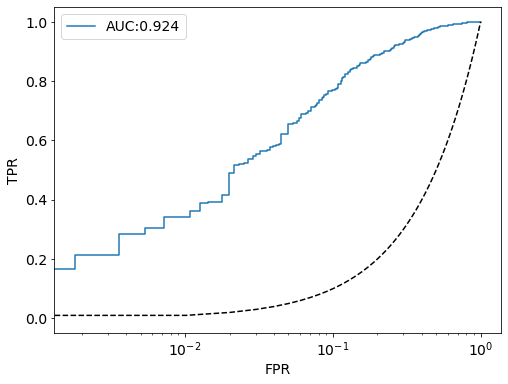

In [8]:
# Now let us evaluate our performance
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CMHE[:, max_treat_idx_CMHE])

In [9]:
# Hyper-parameters to train model
k = 1 
g = 2 
layers = [50, 50] 

model_random_seed = 3
iters = 50
learning_rate = 0.001
batch_size = 128
vsize = 0.15
patience = 3
optimizer = "Adam"

In [10]:
# Set torch and numpy random seeds
torch.manual_seed(model_random_seed)
np.random.seed(model_random_seed)

# Convert training data into torch tensors
x = features_tr.values.astype('float32')
t = outcomes_tr['time'].values.astype('float32')
e = outcomes_tr['event'].values.astype('float32')
a = interventions_tr.values.astype('float32')
print(f'Shape of covariates: {x.shape} | times: {t.shape} | events: {e.shape} | interventions: {a.shape}')

from models.cmhe import DeepCoxMixturesHeterogenousEffects

# Instantiate the CMHE model
model = DeepCoxMixturesHeterogenousEffects(k=k, g=g, layers=layers)

model = model.fit(x, t, e, a, vsize=vsize, val_data=None, iters=iters, 
                  learning_rate=learning_rate, batch_size=batch_size, 
                  optimizer=optimizer, random_state=model_random_seed, 
                  patience=patience)

Shape of covariates: (3899, 8) | times: (3899,) | events: (3899,) | interventions: (3899,)


100%|██████████████████████████████████████████| 50/50 [01:13<00:00,  1.48s/it]


In [11]:
print(f'Treatment Effect for the {g} groups: {model.torch_model[0].omega.detach()}')

x = features_tr.values.astype('float32')
a = interventions_tr.values.astype('float32')
zeta_probs_train = model.predict_latent_phi(x)
# zeta_probs_train = predict_treatment_phenotype_proba(model, x, a)

zeta_train =  np.argmax(zeta_probs_train, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CMHE = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CMHE} has the maximum restricted mean survival time on the training data!')

Treatment Effect for the 2 groups: tensor([-0.4854,  0.2729])
Distribution of individuals in each treatement phenotype in the training data: [1569 2330]

Group 1 has the maximum restricted mean survival time on the training data!


/zfsauton2/home/mgoswami/anaconda3/envs/cox-subgroup/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


In [12]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

# Change the testing data to torch tensors
x = features_te.values.astype('float32')
a = interventions_te.values.astype('float32')

zeta_probs_test_CMHE = model.predict_latent_phi(x)
# zeta_probs_test_CMHE = predict_treatment_phenotype_proba(model, x, a)
zeta_test =  np.argmax(zeta_probs_test_CMHE, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test, return_counts=True)[1]}')

Distribution of individuals in each treatement phenotype in the test data: [485 616]


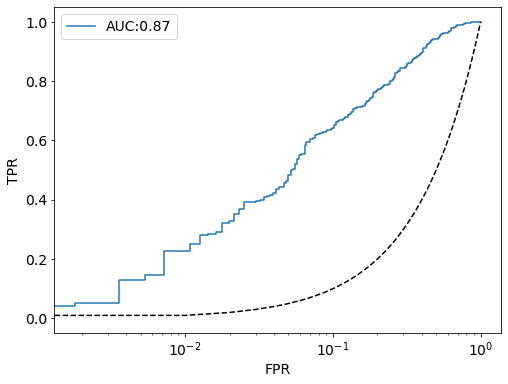

In [13]:
# Now let us evaluate our performance
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CMHE[:, max_treat_idx_CMHE])

## Comparison with the Clustering phenotyper

In [14]:
hyperparam_grid = {'clustering_method': ['kmeans', 'gmm'],
                   'n_clusters': [3, 2],
                   'dim_red_method': [None]}

In [15]:
from phenotyping import ClusteringPhenotyper
from sklearn.metrics import auc

clustering_method = 'gmm'
dim_red_method = None # We would not perform dimensionality reduction for the synthetic dataset
n_components = None 
n_clusters = g # Number of underlying treatment effect phenotypes

# Running the phenotyper
phenotyper = ClusteringPhenotyper(clustering_method=clustering_method, 
                                  dim_red_method=dim_red_method, 
                                  n_components=n_components, 
                                  n_clusters=n_clusters)

zeta_probs_train = phenotyper.fit_phenotype(features_tr.values)
zeta_train = np.argmax(zeta_probs_train, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CP = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CP} has the maximum restricted mean survival time on the training data!')

No Dimensionaity reduction specified...
 Proceeding to learn clusters with the raw features...
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3)
Distribution of individuals in each treatement phenotype in the training data: [ 612 1408 1879]

Group 2 has the maximum restricted mean survival time on the training data!


/zfsauton2/home/mgoswami/anaconda3/envs/cox-subgroup/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


In [16]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

# Change the testing data to torch tensors
x = features_te.values.astype('float32')
a = interventions_te.values.astype('float32')

# Use the phenotyper trained on training data to phenotype on testing data
zeta_probs_test_CP = phenotyper.phenotype(features_te.values)
zeta_test_CP =  np.argmax(zeta_probs_test_CP, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test_CP, return_counts=True)[1]}')

Distribution of individuals in each treatement phenotype in the test data: [151 445 505]


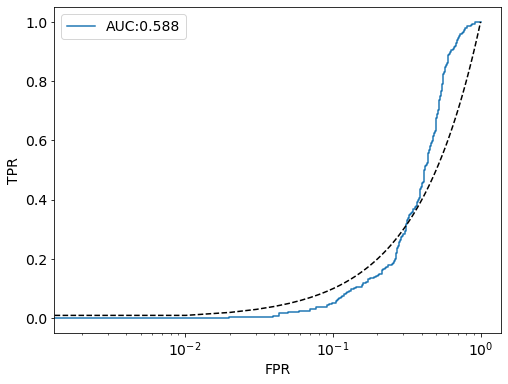

In [17]:
# Now let us evaluate our performance
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CP[:, max_treat_idx_CP])